In [1]:
!pip install ndlinear

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
pip install -q torchaudio einops fvcore torchinfo tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import os, time, math, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import torchaudio, torchaudio.transforms as T
from fvcore.nn import FlopCountAnalysis, parameter_count_table
from torchinfo import summary
from ndlinear import NdLinear

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

os.makedirs('./data', exist_ok=True)

device: cuda


In [ ]:
class SpeechCommandsDataset(torchaudio.datasets.SPEECHCOMMANDS):
    def __init__(self, root, subset):
        super().__init__(root, download=True)
        def _load_list(fname):
            p = os.path.join(self._path, fname)
            with open(p) as f:
                return [os.path.join(self._path, line.strip()) for line in f]
        if subset == 'validation':
            self._walker = _load_list('validation_list.txt')
        elif subset == 'testing':
            self._walker = _load_list('testing_list.txt')
        elif subset == 'training':
            excludes = set(_load_list('validation_list.txt') + _load_list('testing_list.txt'))
            self._walker = [w for w in self._walker if w not in excludes]
        else:
            raise ValueError(subset)

SAMPLE_RATE, N_MELS = 16_000, 40
mel_spec = T.MelSpectrogram(sample_rate=SAMPLE_RATE,
                            n_fft=640, hop_length=320, n_mels=N_MELS)

def _pad(batch):
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True)
    return batch.permute(0, 2, 1)               # (B, mel, time)

class Collate:
    def __call__(self, batch):
        waves, labels = [], []
        for wav, _, lbl, *_ in batch:
            if wav.shape[0] > 1:                
                wav = wav.mean(dim=0, keepdim=True)
            spec = mel_spec(wav).squeeze(0)        
            waves.append(spec.transpose(0, 1))     
            labels.append(lbl)

        waves = _pad(waves)                        
        label_set = sorted(set(labels))
        lmap = {l: i for i, l in enumerate(label_set)}
        labels = torch.tensor([lmap[l] for l in labels])
        return waves, labels, label_set


In [ ]:
class DSCNN(nn.Module):
    """
    Depthwise-separable CNN for keyword spotting.
    Set use_nd=True to replace 1×1 conv & final FC with NdLinear.
    """
    def __init__(self, num_classes, width_mult=1.0,
                 use_nd=False, rank_ratio=0.5, channels=1):
        super().__init__()
        self.use_nd = use_nd
        def dw(in_ch, stride=1):
            return nn.Conv2d(in_ch, in_ch, 3, stride, 1, groups=in_ch, bias=False)
        def pw(in_ch, out_ch):
            return nn.Conv2d(in_ch, out_ch, 1, bias=False)

        cfg = [64, 64, 128, 128, 256, 256]      # out channels
        strides = [2, 1, 2, 1, 2, 1]
        layers, in_ch = [], channels
        for out_ch, s in zip(cfg, strides):
            out_ch = int(out_ch * width_mult)
            layers += [dw(in_ch, s)]
            if use_nd and in_ch == out_ch:       
                layers += [nn.Identity()]        
            else:
                layers += [pw(in_ch, out_ch)]
            layers += [nn.ReLU(inplace=True)]
            in_ch = out_ch
        self.features = nn.Sequential(*layers)

        if use_nd:
            hidden = int(in_ch * rank_ratio)

            
            self.pool = nn.AdaptiveAvgPool2d((1, 1))

            # ❷ NdLinear sees shape (C, 1) → (hidden, 1)
            self.nd    = NdLinear((in_ch, 1), (hidden, 1))
            self.relu  = nn.ReLU()
            self.fc    = nn.Linear(hidden, num_classes)
        else:
            self.pool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc   = nn.Linear(in_ch, num_classes)

    def forward(self, x):               
        x = x.unsqueeze(1)              
        x = self.features(x)            
        x = self.pool(x).squeeze(-1)    

        if self.use_nd:
            x = self.nd(x)              # (B,hidden,1)
            x = self.relu(x)
            x = x.squeeze(-1)           # (B,hidden)

        else:                           
            x = x.squeeze(-1)           

        return self.fc(x)


In [ ]:
def train_epoch(model, loader, optim, loss_fn):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in loader:                  
        xb, yb = xb.to(device), yb.to(device)
        optim.zero_grad(set_to_none=True)
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optim.step()
        loss_sum += loss.item() * xb.size(0)
        correct += (out.argmax(1) == yb).sum().item()
        total += xb.size(0)
    return loss_sum / total, correct / total

@torch.no_grad()
def eval_acc(model, loader):
    model.eval()
    total, correct = 0, 0
    for xb, yb in loader:                  
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        correct += (out.argmax(1) == yb).sum().item()
        total += xb.size(0)
    return correct / total


In [ ]:
root = '/content/data'

# ── 1.  build a GLOBAL label list  ────────────────────────────────────────────
train_full = SpeechCommandsDataset(root, 'training')
LABELS = sorted({sample[2] for sample in train_full})   
label_to_idx = {lbl: i for i, lbl in enumerate(LABELS)}
NUM_CLASSES = len(LABELS)
print("Detected", NUM_CLASSES, "classes:", LABELS[:8], "...")

# ── 2.  collate that uses the global mapping  ────────────────────────────────
class Collate:
    def __call__(self, batch):
        waves, ys = [], []
        for wav, _, lbl, *_ in batch:
            if wav.shape[0] > 1:                    
                wav = wav.mean(dim=0, keepdim=True)
            spec = mel_spec(wav).squeeze(0).transpose(0, 1)  
            waves.append(spec)
            ys.append(label_to_idx[lbl])            
        waves = _pad(waves)                        
        return waves, torch.tensor(ys)

# ── 3.  data loaders  ────────────────────────────────────────────────────────
def make_loader(subset, shuffle):
    ds = SpeechCommandsDataset(root, subset)
    return DataLoader(ds, batch_size=128, shuffle=shuffle,
                      collate_fn=Collate(), num_workers=2, pin_memory=True)

train_dl = make_loader('training',   True)
val_dl   = make_loader('validation', False)
test_dl  = make_loader('testing',    False)

# ── 4.  instantiate models with the correct class count  ────────────────────
baseline = DSCNN(NUM_CLASSES, use_nd=False).to(device)
ndmodel  = DSCNN(NUM_CLASSES, use_nd=True, rank_ratio=0.5).to(device)


Detected 35 classes: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five'] ...


In [20]:
def run_experiment(model, name, epochs=3, lr=8e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best = 0.0
    for ep in range(1, epochs + 1):
        tr_loss, tr_acc = train_epoch(model, train_dl, optimizer, criterion)
        val_acc = eval_acc(model, val_dl)
        best = max(best, val_acc)
        print(f"{name} | epoch {ep}/{epochs} "
              f"| train_acc={tr_acc:.3f} | val_acc={val_acc:.3f}")
    print(f"{name} | best_val_acc={best:.3f}")
    return best

best_base = run_experiment(baseline, 'baseline')
best_nd   = run_experiment(ndmodel,  'ndlinear')

print("→ Test accuracy baseline:", eval_acc(baseline, test_dl))
print("→ Test accuracy NdLinear:", eval_acc(ndmodel,  test_dl))


baseline | epoch 1/3 | train_acc=0.640 | val_acc=0.661
baseline | epoch 2/3 | train_acc=0.674 | val_acc=0.682
baseline | epoch 3/3 | train_acc=0.697 | val_acc=0.690
baseline | best_val_acc=0.690
ndlinear | epoch 1/3 | train_acc=0.654 | val_acc=0.676
ndlinear | epoch 2/3 | train_acc=0.692 | val_acc=0.693
ndlinear | epoch 3/3 | train_acc=0.715 | val_acc=0.726
ndlinear | best_val_acc=0.726
→ Test accuracy baseline: 0.6873239436619718
→ Test accuracy NdLinear: 0.7125851885506588


In [ ]:

sample, _ = next(iter(train_dl))    
sample = sample.to(device)

for mdl, name in ((baseline, 'baseline'), (ndmodel, 'ndlinear')):
    mdl.eval()                     
    flops = FlopCountAnalysis(mdl, sample)
    print(f"=== {name} ===")
    print(f"FLOPs: {flops.total() / 1e6:.1f} M")
    print(parameter_count_table(mdl))



nd.relu


=== baseline ===
FLOPs: 1211.7 M
| name                  | #elements or shape   |
|:----------------------|:---------------------|
| model                 | 0.1M                 |
|  features             |  0.1M                |
|   features.0          |   9                  |
|    features.0.weight  |    (1, 1, 3, 3)      |
|   features.1          |   64                 |
|    features.1.weight  |    (64, 1, 1, 1)     |
|   features.3          |   0.6K               |
|    features.3.weight  |    (64, 1, 3, 3)     |
|   features.4          |   4.1K               |
|    features.4.weight  |    (64, 64, 1, 1)    |
|   features.6          |   0.6K               |
|    features.6.weight  |    (64, 1, 3, 3)     |
|   features.7          |   8.2K               |
|    features.7.weight  |    (128, 64, 1, 1)   |
|   features.9          |   1.2K               |
|    features.9.weight  |    (128, 1, 3, 3)    |
|   features.10         |   16.4K              |
|    features.10.weight |    (128, 1

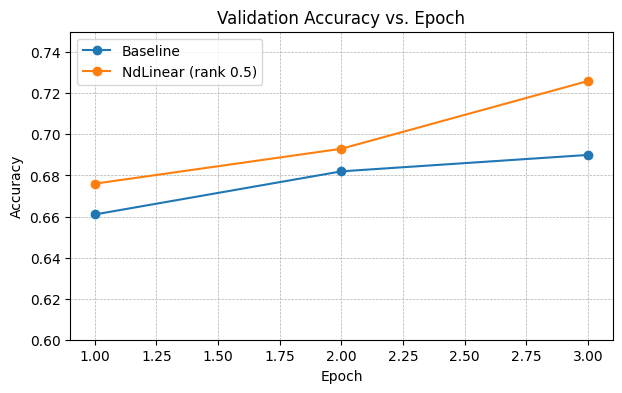

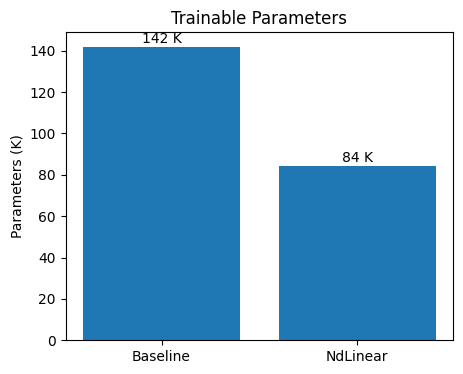

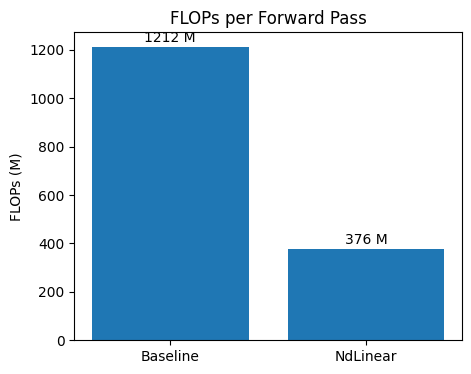

In [ ]:
# ── Plot baseline vs NdLinear results ─────────────────────────────────────────
import matplotlib.pyplot as plt
import numpy as np

# ── 1) Validation-accuracy curves ─────────────────────────────────────────────
epochs           = [1, 2, 3]                     
val_acc_baseline = [0.661, 0.682, 0.690]         # baseline val-acc per epoch
val_acc_nd       = [0.676, 0.693, 0.726]         # NdLinear val-acc per epoch

plt.figure(figsize=(7,4))
plt.plot(epochs, val_acc_baseline, marker='o', label='Baseline')
plt.plot(epochs, val_acc_nd,       marker='o', label='NdLinear (rank 0.5)')
plt.title('Validation Accuracy vs. Epoch')
plt.xlabel('Epoch');  plt.ylabel('Accuracy');  plt.ylim(0.6, 0.75)
plt.grid(True, linestyle='--', linewidth=0.5);  plt.legend()
plt.show()

# ── 2) Parameter count bar plot ───────────────────────────────────────────────
models  = ['Baseline', 'NdLinear']
paramsK = [141.8, 84.2]            

plt.figure(figsize=(5,4))
plt.bar(models, paramsK)
plt.title('Trainable Parameters');  plt.ylabel('Parameters (K)')
for x,y in zip(models, paramsK):
    plt.text(x, y+2, f'{y:.0f} K', ha='center')
plt.show()

# ── 3) FLOPs per inference bar plot ───────────────────────────────────────────
flopsM = [1211.7, 376.5]           # numbers in **millions** of FLOPs

plt.figure(figsize=(5,4))
plt.bar(models, flopsM)
plt.title('FLOPs per Forward Pass');  plt.ylabel('FLOPs (M)')
for x,y in zip(models, flopsM):
    plt.text(x, y+20, f'{y:.0f} M', ha='center')
plt.show()
